In [ ]:
#Copy data to local scratch
import os
datasetName = "geler"
datasetFrom = "/home/xca64/remote/GitHub/colorP/dataSet/" + datasetName
datasetTo = "/local-scratch/xca64/"
cpCommand = "cp -rf " + datasetFrom + " " + datasetTo 
rmCommand = "rm -rf " +  datasetTo + datasetName 
print cpCommand 
os.system(cpCommand)

In [1]:
import os
os.chdir('../../')
import sys
sys.path.insert(0, './python')
sys.path.append('/local-scratch/xca64/tmp/caffe-master/python/myFunc')
import caffe
import numpy as np
from pylab import *
%matplotlib inline

In [2]:
niter = 200
# losses will also be stored in the log
train_loss = np.zeros(niter)
scratch_train_loss = np.zeros(niter)

caffe.set_device(0)
caffe.set_mode_gpu()

In [3]:
solver = caffe.SGDSolver('models/color_constancy/gehler_482_solver.prototxt')
solver.net.copy_from('models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')

In [4]:
import tempfile

In [5]:
def run_solver(solver, niter, disp_interval):
    blobs = ('loss', 'acc')
    loss, acc = (np.zeros(niter), np.zeros(niter))
    for it in range(niter):
        solver.step(1)  # run a single SGD step in Caffe
        loss[it] = (solver.net.blobs['loss'].data.copy())
        acc[it] = 0#(solver.net.blobs['loss_ang'].data.copy())
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = 'loss: %.3f'%loss[it]
            print '%3d) %s Angular Erro %.3f' % (it, loss_disp, acc[it])     
            print(solver.net.blobs['fc8_flickr'].data[1], solver.net.blobs['illu'].data[1])
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    name = 'firstTry'
    weights = {}
    filename = 'weights.%s.caffemodel' % name
    
    weights[name] = os.path.join(weight_dir, filename)
    solver.net.save(weights[name])
    
    return loss, acc, weights

In [ ]:
loss_1, acc_1, weights_1 = run_solver(solver, 1000,10)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [6]:
def deprocess_net_image(image, gamma):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255
    
    image = image.astype(np.float32)
    image = image/255
    image = image**gamma #Gamma correction
    image = image*255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image


In [7]:
def my_deprocess_net_image(image, gamma):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC
    #image += [123, 117, 104]          # (approximately) undo mean subtraction

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255
    
    image = image.astype(np.float32)
    image = image/255
    image = image**gamma #Gamma correction
    image = image*255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [8]:
solver.step(1)  # SGD by Caffe

[ 0.0483994  0.0427776  0.0404933]
[ 0.0406068  0.0364151  0.035649 ]
[ 0.1531402   0.1356553   0.12864821]
[ 0.1292548  0.1173989  0.1107552]
[ 0.1236585  0.1087753  0.1015189]


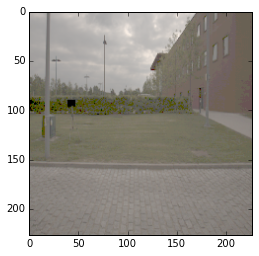

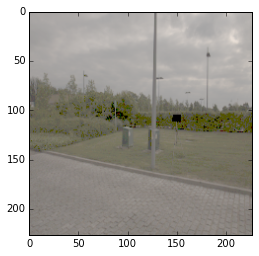

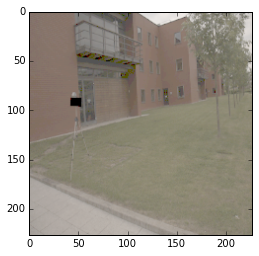

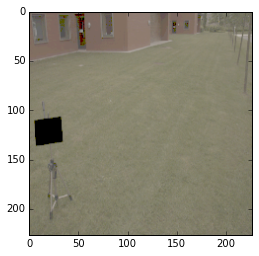

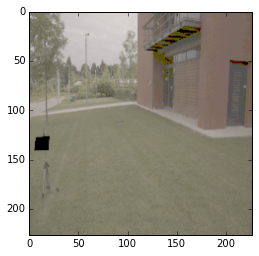

In [11]:
for i in range(0,5):
    img = my_deprocess_net_image(solver.net.blobs['data'].data[i], 0.2)
    print solver.net.blobs['illu'].data[i]
    plt.figure(i)
    plt.imshow(img)


In [ ]:
for i in range(0,5):
    img = deprocess_net_image(solver.net.blobs['data'].data[i], 1)
    print solver.net.blobs['illu'].data[i]
    plt.figure(i)
    plt.imshow(img)

In [ ]:
print np.min(solver.net.blobs['data'].data[1])
print solver.net.blobs['data'].num

In [ ]:
os.system(rmCommand)

In [ ]:
# We run the solver for niter times, and record the training loss.
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    if it % 10 == 0:
        print 'iter %d, finetune_loss=%f, scratch_loss=' % (it, train_loss[it])
print 'done'